# Arabic Text Classification
<font size = 5> Hazem Mohamed Abdelghafar 211001615</font>


# Library Imports

In [101]:
import os
import re
import nltk
import string
import numpy as np
import pandas as pd 
from sklearn import metrics
import matplotlib.pyplot as plt
from gradio import ChatInterface
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing import text_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Embedding, Conv1D, Dense, MaxPooling1D, Flatten

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zoma_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset Reading and Info

In [102]:
paths = '../Dataset'

raw_data = text_dataset_from_directory(
    paths,
    labels = "inferred",
    label_mode = "int",
    max_length = None,
    shuffle=True,
    seed=42,
)

Found 45500 files belonging to 7 classes.


In [103]:
x=[]
y=[]
for text_batch, label_batch in raw_data:
    for i in range(len(text_batch)):
        s=text_batch.numpy()[i].decode("utf-8") 
        x.append(s)
        y.append(raw_data.class_names[label_batch.numpy()[i]])
print(len(x))
print(len(y))

45500
45500


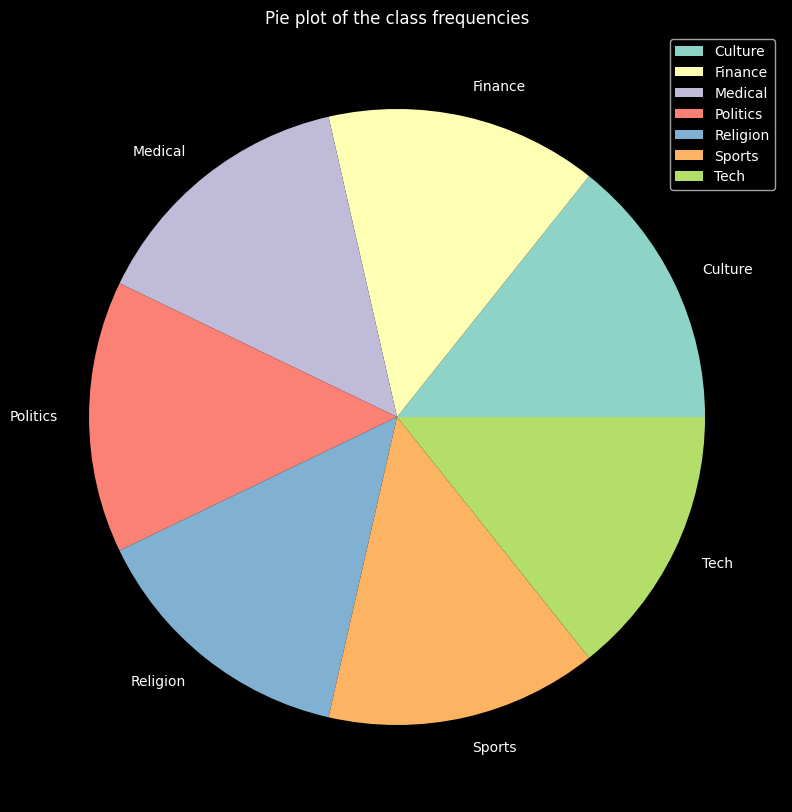

In [104]:
labels = os.listdir('../Dataset') 

unique, counts = np.unique(y, return_counts=True) #plt y 
plt.figure("classe Pie", figsize=(10, 10))
plt.title("Pie plot of the class frequencies")
plt.pie(counts, labels=labels)
plt.legend(unique)
plt.show()

In [105]:
data =pd.DataFrame({"Text":x,"label":y})
data.sample(5)

,Text,label
31907,"أبوظبي - ""الخليج"":تقوم الهيئة ببناء الإطار الت...",Tech
7108,ألغى رئيس الوزراء التركي رجب طيب أردوغان أمس، ...,Politics
39012,وردت أحاديث كثيرة، تتضمن فوز الكثيرين من الصحا...,Religion
41915,تودع أسواق الأسهم المحلية توزيع الأرباح على ال...,Finance
44297,أصدرت الهيئة المصرية العامة للكتاب، كتاباً بعن...,Culture


In [106]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45500 entries, 0 to 45499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    45500 non-null  object
 1   label   45500 non-null  object
dtypes: object(2)
memory usage: 711.1+ KB
None


In [107]:
print('Is null ?:\n')
print(data.isnull().sum(), "\n")
print('is duplicated:', data.duplicated().sum(), "\n")
print('data shape:', data.shape, "\n")

Is null ?:

Text     0
label    0
dtype: int64 

is duplicated: 15 

data shape: (45500, 2) 



# Data Preprocessing

In [108]:
data.drop_duplicates(inplace=True)

In [109]:
stop_words = list(set(stopwords.words('arabic')))

In [110]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [111]:
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [112]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    text = remove_emoji(text)
    text = remove_diacritics(text)
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = (re.sub(r'[\W\s]', ' ', text))
    return text

In [113]:
data['cleaned_text'] = data['Text'].apply(clean_text)

In [114]:
print("Text before cleaning: ")
print(data['Text'][10])
print()
print("Text after cleaning: ")
print(data['cleaned_text'][10])

Text before cleaning: 
كشف الدكتور سعيد الظاهري مستشار وزير الخارجية لنظم المعلومات خلال أسبوع جيتكس التقني أن الوزارة أطلقت 28 خدمة جديدة لتصل نسبة تحولها إلى الخدمات الذكية الى 85% بنحو 79 خدمة خلال موقعها الإلكتروني على شبكة الإنترنت وفقاً لمعايير حكومة الإمارات الإلكترونية وتماشياً مع توجهات الحكومة الاتحادية في التحول إلى حكومة ذكية، في حين تعد الوزارة من السباقين في التبني والتحول إلى الأنظمة الإلكترونية الذكية والحديثة .وأضاف أن الخدمات المضافة تعزز من قطاع الأعمال وتقدم له أغلبية الخدمات، في حين يقدم الموقع الخدمات الداخلية للوزارة من خلال نظام وزارة إلى وزارة، إضافة إلى خدمة مواطني الإمارات، وبذلك تصل خدمات الجمهور الإلكترونية والذكية بنسبة 100%، من خلال الموقع ومن خلال تطبيق وزارة الخارجية الإلكتروني على نظام تشغيل أندرويد الذي تم الإفصاح عنه في جيتكس، إضافة إلى نظام أي أو إس الخاص بأجهزة ايفون وأجهزة أي باد .ويشير الظاهري إلى أن الوزارة سعت وبشكل كبير من أجل تحسين مستوى خدمة المواطنين والمتعاملين من خلال الخدمات الإلكترونية التي وصلت الى 100%، وفي حين تسعى لكي ترفع خدمات الو

In [115]:
label_encoder = LabelEncoder()
data['encodedLabel'] = label_encoder.fit_transform(data['label'])
data.head()

,Text,label,cleaned_text,encodedLabel
0,رأس الخيمة - عدنان عكاشة:قال د . عبد الله النع...,Medical,رأس الخيمة عدنان عكاشةقال عبد الله النعيمي مد...,2
1,انخفض مؤشر سوق الإمارات منذ بداية العام الحالي...,Finance,انخفض مؤشر سوق الإمارات بداية العام الحالي بنس...,1
2,أهدى الرئيس الشيشاني رمضان قديروف النجم المصري...,Sports,أهدى الرئيس الشيشاني رمضان قديروف النجم المصري...,5
3,أعلن مكتب الملكة رانيا عقيلة العاهل الأردني ال...,Politics,أعلن مكتب الملكة رانيا عقيلة العاهل الأردني ال...,3
4,حوار:جمال سالم يعد المستعرب والمستشرق الروسي «...,Religion,حوارجمال سالم يعد المستعرب والمستشرق الروسي ...,4


In [116]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['encodedLabel'], test_size=0.20, random_state=42)

# Model Building

In [117]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) 
X_train_tfidf.shape

(36388, 447770)

## Support Vector Machine

In [118]:
clf = LinearSVC(verbose=1)
clf.fit(X_train_tfidf,y_train)

c:\Users\zoma_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]

LinearSVC(verbose=1)

In [119]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),])

text_clf.fit(X_train, y_train) 

predictions_svc = text_clf.predict(X_test)

c:\Users\zoma_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


## CNN Model

In [120]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(data['cleaned_text'])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

X_train_cnn = tokenizer.texts_to_sequences(X_train)
X_test_cnn = tokenizer.texts_to_sequences(X_test)

X_train_cnn = pad_sequences(X_train_cnn, maxlen=MAX_SEQUENCE_LENGTH)
X_test_cnn = pad_sequences(X_test_cnn, maxlen=MAX_SEQUENCE_LENGTH)

y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

Found 504301 unique tokens.


In [121]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train_cnn.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\zoma_\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [122]:
epochs = 3
batch_size = 128

history = model.fit(X_train_cnn, y_train_cnn,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_cnn, y_test_cnn))

predictions_cnn = model.predict(X_test_cnn)

Epoch 1/3
285/285 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6416 - loss: 0.9328 - val_accuracy: 0.9712 - val_loss: 0.1087
Epoch 2/3
285/285 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.9936 - loss: 0.0303 - val_accuracy: 0.9700 - val_loss: 0.1215
Epoch 3/3
285/285 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9716 - val_loss: 0.1283
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# Model Evaluation

In [123]:
y_test_argmax = np.argmax(y_test_cnn, axis=1)
predictions_cnn_argmax = np.argmax(predictions_cnn, axis=1)

## Support Vector Machine

In [124]:
print(classification_report(y_test,predictions_svc))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1232
           1       0.99      0.98      0.99      1292
           2       0.98      0.99      0.98      1277
           3       0.98      0.99      0.98      1357
           4       0.98      0.96      0.97      1303
           5       0.99      1.00      0.99      1349
           6       0.97      0.98      0.98      1287

    accuracy                           0.98      9097
   macro avg       0.98      0.98      0.98      9097
weighted avg       0.98      0.98      0.98      9097



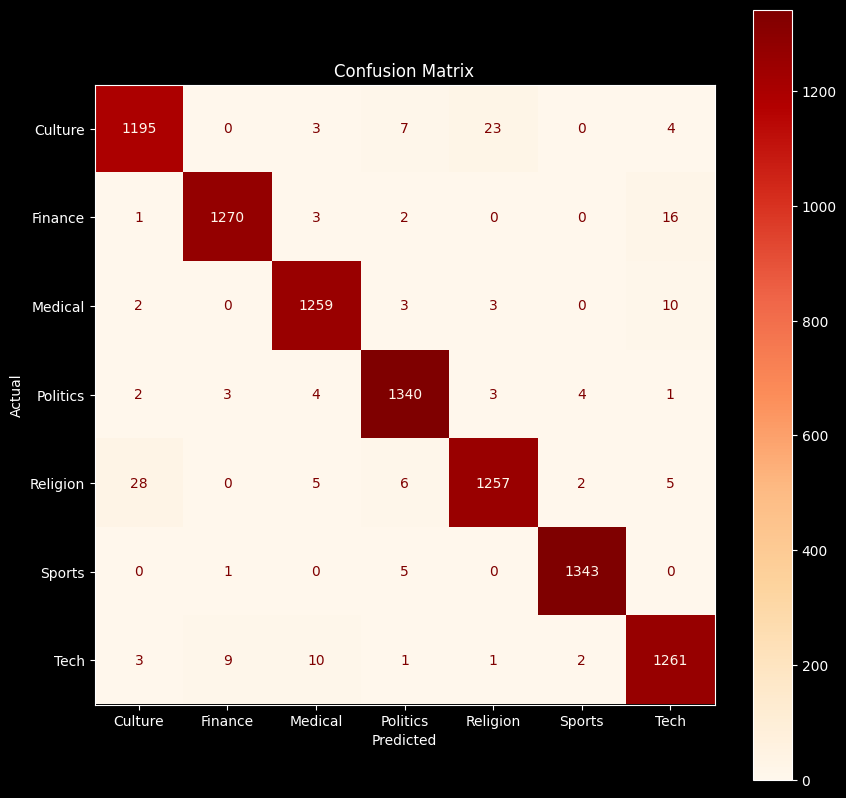

In [125]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
cm = confusion_matrix(y_test, predictions_svc)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=labels).plot(values_format='d',cmap='OrRd', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## CNN Model

In [126]:
print(metrics.classification_report(y_test_argmax, predictions_cnn_argmax))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1232
           1       0.98      0.98      0.98      1292
           2       0.96      0.99      0.97      1277
           3       0.97      0.98      0.97      1357
           4       0.97      0.95      0.96      1303
           5       0.99      0.99      0.99      1349
           6       0.97      0.96      0.97      1287

    accuracy                           0.97      9097
   macro avg       0.97      0.97      0.97      9097
weighted avg       0.97      0.97      0.97      9097



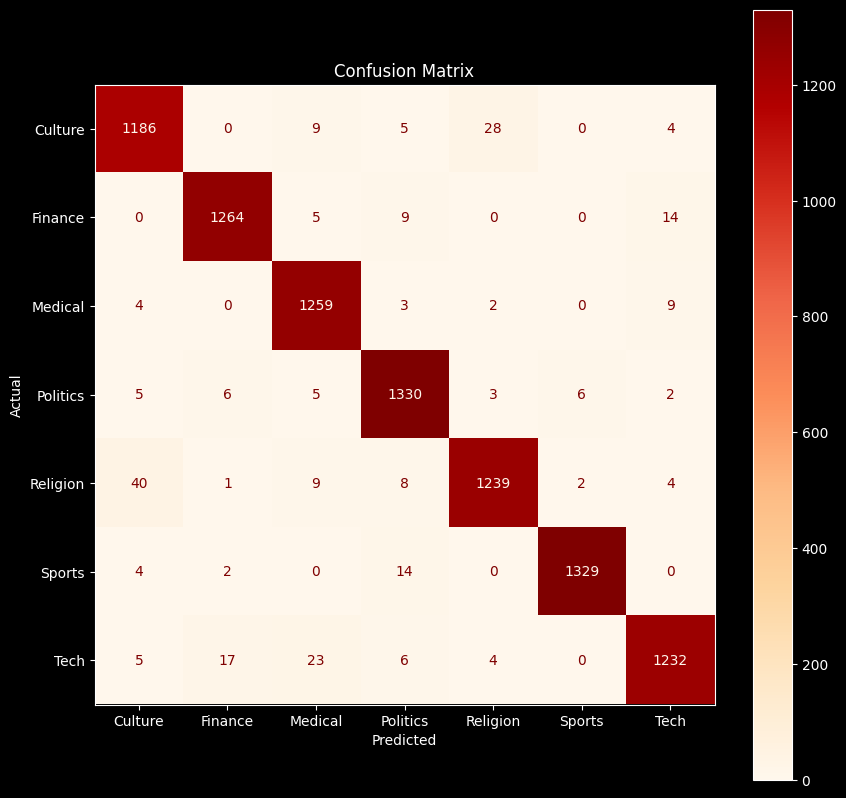

In [127]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
cm = confusion_matrix(y_test_argmax, predictions_cnn_argmax)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=labels).plot(values_format='d',cmap='OrRd', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

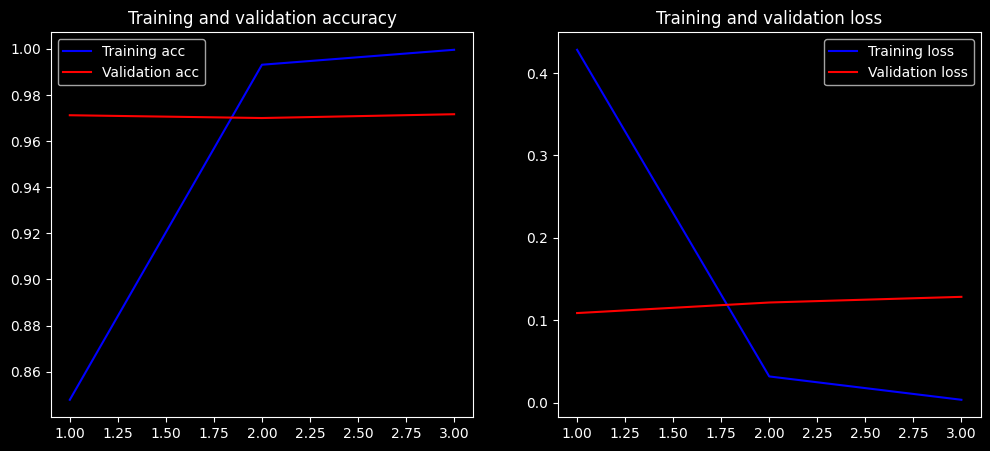

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Chatbot

## SVM Chatbot Classifier

In [129]:
def chatbot_svm(message,_):    
    respone = ''

    message = clean_text(message)
    output = text_clf.predict([message])[0]
    respone = label_encoder.inverse_transform([output])[0]
    return respone

In [130]:
svm_chatbot = ChatInterface(chatbot_svm, title="SVM Chatbot", description="A chatbot that uses a Support Vector Machine to classify Arabic text.")

svm_chatbot.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


## CNN Chatbot Classifier

In [131]:
def chatbot_cnn(message,_):    
    response = ''

    clean_message = clean_text(message)
    tokenized = tokenizer.texts_to_sequences([clean_message])
    padded = pad_sequences(tokenized, maxlen=MAX_SEQUENCE_LENGTH)
    output = model.predict(padded)
    output = np.argmax(output[0])
    response = label_encoder.inverse_transform([output])[0]
    return response

In [132]:
svm_chatbot = ChatInterface(chatbot_cnn, title="CNN Chatbot Classifier", description="A chatbot that uses a Convultional Neural Network to classify Arabic text.")

svm_chatbot.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
